This script extends the simple example posed in CompareGammaDistribution by examining a generic Markov chain with forward and backward transition rates.

Last updated by: Jonathan Liu, 10/20/2020

In [1]:
#Import necessary packages
#matplotlib inline
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import scipy.special as sps

In [45]:
#Simulation for calculating onset times for a generic Markov chain

def CalculatetOn_GenericMarkovChain(time,dt,Q,n,N_cells):
#Calculates the onset time for a linear Markov chain with forward and backward rates.
#The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes n states, beginning
#in the 1st state. Using finite timesteps and a Markov chain formalism, it
#simulates N_cells realizations of the overall time it takes to reach the
#nth state.

# Inputs:
#   time: simulation time vector
#   dt: simulation timestep
#   Q: 3D transition rate matrix, where q_kji is the transition rate at time k from state i to j for i =/= j and 
#      q_kii is the sum of transition rates out of state i
#   n: number of states
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.empty(N_cells) #Time to transition to final ON state for each cell
    t_on[:] = np.nan
    state = np.zeros(N_cells, dtype=int) #State vector describing current state of each cell
    finished_states = np.zeros(N_cells, dtype=int) #Vector storing finished statuses of each cell

    ## Run simulation
    #Loop over time
    #q = waitbar(0,'Running simulation...')
    for i in range(len(time)):
        if np.sum(finished_states) == N_cells: #If all cells have turned on, stop the simulation
            #print('Halting simulation since all cells have turned on.')
            break
        
        #Simulate binomial random variable to see if each cell has transitioned
        #If the input transition rate is a nan, this will manifest as never
        #transitioning.
        
        #Find indices of that have not finished yet
        incompleteCells = np.transpose(np.where(finished_states != 1))
        #Loop over cells
        for j in incompleteCells:
            #The probability that a state i switches is given by -Q_ii * dt
            p = -Q[i,state[j],state[j]] * dt #Probability of transition at this timestep for this cell
            transitioned = np.random.binomial(1,p,1) #Binary transition decision for this cell

            #The state to transition to is given by the ratio of the individual rates in the column j over the total rate -Q_ii
            if transitioned == 1:
                Q_temp = np.copy(Q) #Temporary matrix where we will remove Q_ii for this cell and state
                Q_temp[i,state[j],state[j]] = 0
                pState = np.squeeze(Q_temp[i,:,state[j]]/-Q[i,state[j],state[j]])
                #print(Q[i,:,:])
                newState = np.random.choice(n, 1, p=pState)
                #print('cell ' + str(j) + ' transitioned from state ' + str(state[j]) + \
                #      ' to state ' + str(newState) + 'at time ' + str(time[i]))                
                state[j] = newState
                
                #Record the time if it transitioned to the new state
                if newState == n-1:
                    t_on[j] = time[i]

        #See if any states have reached the ON state
        finished_states[state == n-1] = 1
    return t_on

In [3]:
#Test this script with the simple case of equal irreversible transitions

#Function for analytical Gamma distribution
def GamPDF(x,shape,rate):
    return x**(shape-1)*(np.exp(-bins*rate) / sps.gamma(shape)*(1/rate)**shape)

#First, with constant rate
time = np.arange(0,10,0.1)
dt = 0.1
w = 1
N_cells = 1000

#Transition matrix examples
Q_2 = np.array([[-w,0],[w,0]]) #two states
Q_3 = np.array([[-w,0,0],[w,-w,0],[0,w,0]])
Q_4 = np.array([[-w,0,0,0],[w,-w,0,0],[0,w,-w,0],[0,0,w,0]])

#Tile into the time dimension
Q_2_full = np.tile(Q_2,(len(time),1,1))
Q_3_full = np.tile(Q_3,(len(time),1,1))
Q_4_full = np.tile(Q_4,(len(time),1,1))

t_on_2 = CalculatetOn_GenericMarkovChain(time,dt,Q_2_full,2,N_cells)
t_on_3 = CalculatetOn_GenericMarkovChain(time,dt,Q_3_full,3,N_cells)
t_on_4 = CalculatetOn_GenericMarkovChain(time,dt,Q_4_full,4,N_cells)

Halting simulation since all cells have turned on.


P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


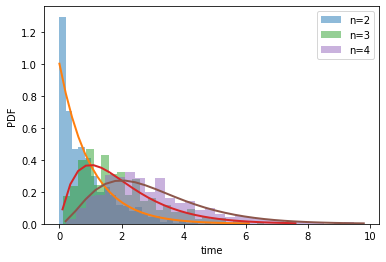

In [5]:
#Plot the distributions
plt.figure()
count, bins, ignored = plt.hist(t_on_2, 30,density=True, alpha=0.5, label='n=2')
plt.plot(bins, GamPDF(bins,1,w), linewidth=2)  
count, bins, ignored = plt.hist(t_on_3, 30,density=True, alpha=0.5, label='n=3')
plt.plot(bins, GamPDF(bins,2,w), linewidth=2)  
count, bins, ignored = plt.hist(t_on_4, 30,density=True, alpha=0.5, label='n=4')
plt.plot(bins, GamPDF(bins,3,w), linewidth=2)  
plt.xlabel('time')
plt.ylabel('PDF')
plt.legend()

Nice, it looks like it works. For next time, try laying down a grid of transition rates to calculate a crude state space area and compare with the transient regime.

Eventually, we need to code up the boundary exploration algorithm.

For now, let's examine the n=2 and n=3 chains in parameter space by laying down a grid of transition rate values. We'll cap the rates at $0.5 < \beta < 5$.

In [7]:
#Function returning the mean and variance of a Gamma distribution
def MeanVarGamDist(shape,rate):
    return shape/rate, shape/rate**2

In [51]:
#Define grid of parameter values
k_min = 1
k_max = 5
k_gap = 1
k_grid = np.arange(k_min,k_max,k_gap)
n = [2,3]

#Analytical results for equal, irreversible transitions (n=2 and n=3 for now)
meanGamma = np.zeros((len(n),len(k_grid)))
varGamma = np.zeros((len(n),len(k_grid)))

for i in range(len(n)):
    for j in range(len(k_grid)):
        meanGamma[i,j], varGamma[i,j] = MeanVarGamDist(n[i]-1,k_grid[j])

#Note that for n=2 the Gamma distribution limit is the full state space, since n=2 is the final state
#and we don't allow reverse transitions from the final state.

#Grid of transition matrices for n=3
Q_3 = []
for i in range(len(k_grid)):
    for j in range(len(k_grid)):
        for k in range(len(k_grid)):
            Q_3.append(np.array([[-k_grid[i],k_grid[j],0],[k_grid[i],-(k_grid[j]+k_grid[k]),0],[0,k_grid[k],0]]))
print('Q_3 done')

Q_3 done


In [52]:
#Simulate distributions
time = np.arange(0,10,0.1)
dt = 0.1
w = 1
N_cells = 1000

#n=3
mean_3 = np.zeros(len(Q_3))
var_3 = np.zeros(len(Q_3))
for i in range(len(Q_3)):
    Q_3_time = np.tile(Q_3[i],(len(time),1,1)) #Tile into the time dimension
    t_on_3 = CalculatetOn_GenericMarkovChain(time,dt,Q_3_time,3,N_cells)
    mean_3[i] = np.nanmean(t_on_3)
    var_3[i] = np.nanvar(t_on_3)
    print(str(i+1) + ' of ' + str(len(Q_3)), end='\r')
                

Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all cells have turned on.
Halting simulation since all ce

Text(0.5, 1.0, 'parameter space for generic Markov chains')

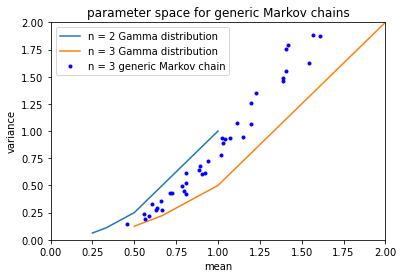

In [55]:
#Plot results
plt.figure()
for i in range(len(n)):
    plt.plot(meanGamma[i,:], varGamma[i,:], label='n = ' + str(n[i]) + ' Gamma distribution')
plt.plot(mean_3,var_3, 'b.', label='n = 3 generic Markov chain')
plt.xlabel('mean')
plt.ylabel('variance')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()
plt.title('parameter space for generic Markov chains')


In [ ]:
a = [0] * 10
print(a)